<a href="https://colab.research.google.com/github/Norceis/radar-project/blob/main/radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation, Concatenate, Conv2DTranspose, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [2]:
with open('data_slices_mulitchannel_6.pickle', 'rb') as f:
    x, y = pickle.load(f)

classes = [
            'BARTEK',
            'KUBA',
            'OSKAR',
            'RAFAL'
]

print(x.shape, y.shape)

# skip classes 0 and 4
x = x[np.where(y != 5)]
y = y[np.where(y != 5)]

x = x[np.where(y != 4)]
y = y[np.where(y != 4)]

print(x.shape, y.shape)

y = to_categorical(y, num_classes=len(classes))

print(x.shape, y.shape)

img_shape = x[0].shape

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

(8184, 54, 216, 7) (8184,)
(5536, 54, 216, 7) (5536,)
(5536, 54, 216, 7) (5536, 4)


In [3]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=img_shape))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

for k in [64, 128, 256, 256 ]:
      model.add(Conv2D(k, (3,3), padding='same'))
      model.add(MaxPooling2D())
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Flatten())
for k in [512, 256, 128]:
      model.add(Dense(k))
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Dense(len(classes), activation='softmax'))
model.summary()


slice = Input(shape=img_shape)
pred = model(slice)
radar_model = Model(slice, pred)

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy')
]

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

# optimizer = Adam(0.0002, 0.5)
radar_model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                        metrics=METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 216, 32)       2048      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 108, 32)      0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 27, 108, 32)       0         
                                                                 
 dropout (Dropout)           (None, 27, 108, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 108, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 54, 64)       0         
 2D)                                                    

In [4]:
history = radar_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[early_callback])

Epoch 1/100
139/139 [==============================] - 73s 501ms/step - loss: 1.3910 - accuracy: 0.7493 - val_loss: 1.3785 - val_accuracy: 0.7500
Epoch 2/100
139/139 [==============================] - 66s 473ms/step - loss: 1.3761 - accuracy: 0.7491 - val_loss: 1.3784 - val_accuracy: 0.7507
Epoch 3/100
139/139 [==============================] - 68s 489ms/step - loss: 1.3582 - accuracy: 0.7503 - val_loss: 1.3392 - val_accuracy: 0.7491
Epoch 4/100
139/139 [==============================] - 67s 485ms/step - loss: 1.3257 - accuracy: 0.7521 - val_loss: 1.3304 - val_accuracy: 0.7532
Epoch 5/100
139/139 [==============================] - 63s 453ms/step - loss: 1.3121 - accuracy: 0.7557 - val_loss: 1.2887 - val_accuracy: 0.7570
Epoch 6/100
139/139 [==============================] - 67s 483ms/step - loss: 1.2917 - accuracy: 0.7553 - val_loss: 1.2687 - val_accuracy: 0.7608
Epoch 7/100
139/139 [==============================] - 63s 457ms/step - loss: 1.2450 - accuracy: 0.7627 - val_loss: 1.2402 -

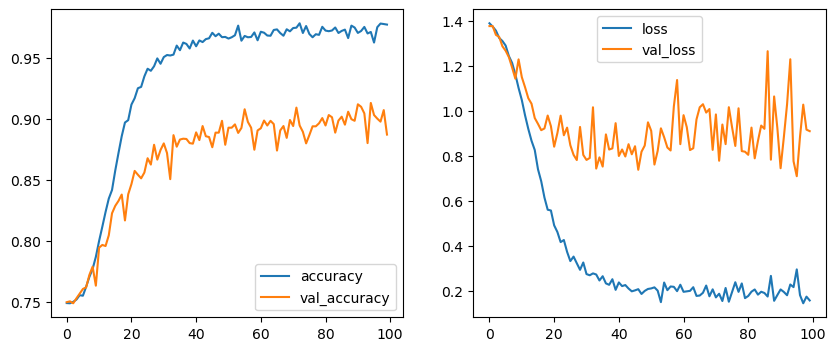

In [5]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(['accuracy', 'val_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss', 'val_loss'])
plt.show()

In [6]:
radar_model.evaluate(x_test, y_test)


35/35 [==============================] - 5s 113ms/step - loss: 0.9104 - accuracy: 0.8874


[0.9104492664337158, 0.8874097466468811]

In [7]:
np.unique(y, return_counts=True)

(array([0., 1.], dtype=float32), array([16608,  5536], dtype=int64))

35/35 [==============================] - 5s 107ms/step


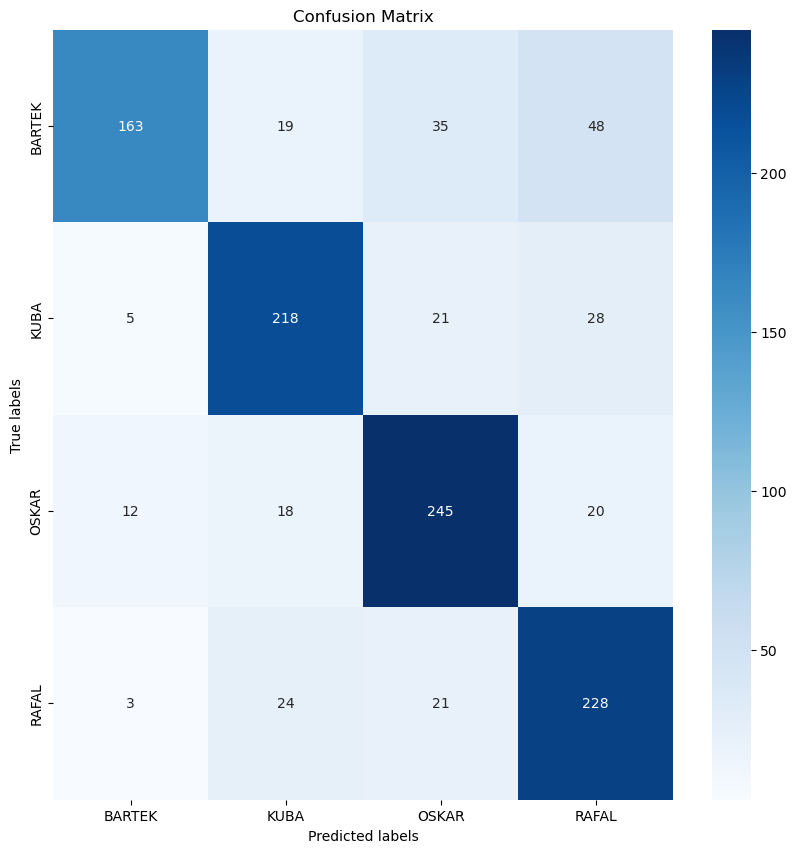

In [8]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = radar_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues',fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()

In [9]:
# save model
radar_model.save('radar_model_big.h5')
